In [2]:
import pandas as pd
import glob

# Load the data from csv files
data = pd.concat([pd.read_csv(f) for f in glob.glob('s*.csv')])

print("---------- DATA ----------")
print(data.head())

print("---------- DATA DIMENSIONS ----------")
print(data.shape)

print("---------- DATA COLUMNS ----------")
print(data.columns)

print("---------- DATA NAN ----------")
print(data.isnull().sum())

---------- DATA ----------
   Unnamed: 0       Vx1       Vy1       Vz1         P1          P2         P3  \
0           0  7.107226  2.857086  0.000000  25.015300  218.231600  29.496900   
1           1  7.566645  1.580754  0.000000  24.615769  217.759186  26.045025   
2           2  8.232815  0.908911 -0.885180  24.720733  215.520299  27.895377   
3           3  7.764773  0.857239 -0.354739  23.817487  214.758024  29.329764   
4           4  7.738041  0.717836  0.871687  21.422593  216.613663  27.234682   

         P4     flowrate  
0  5.227500  1726.176870  
1  0.615990  1682.764884  
2  3.873287  1667.562648  
3  4.891262  1690.969685  
4  4.121431  1660.076591  
---------- DATA DIMENSIONS ----------
(53091, 9)
---------- DATA COLUMNS ----------
Index(['Unnamed: 0', 'Vx1', 'Vy1', 'Vz1', 'P1', 'P2', 'P3', 'P4', 'flowrate'], dtype='object')
---------- DATA NAN ----------
Unnamed: 0     0
Vx1            0
Vy1            0
Vz1            0
P1             0
P2             0
P3          

array([[<AxesSubplot:title={'center':'Vx1'}>,
        <AxesSubplot:title={'center':'Vy1'}>,
        <AxesSubplot:title={'center':'Vz1'}>],
       [<AxesSubplot:title={'center':'P1'}>,
        <AxesSubplot:title={'center':'P2'}>,
        <AxesSubplot:title={'center':'P3'}>],
       [<AxesSubplot:title={'center':'P4'}>,
        <AxesSubplot:title={'center':'flowrate'}>, <AxesSubplot:>]],
      dtype=object)

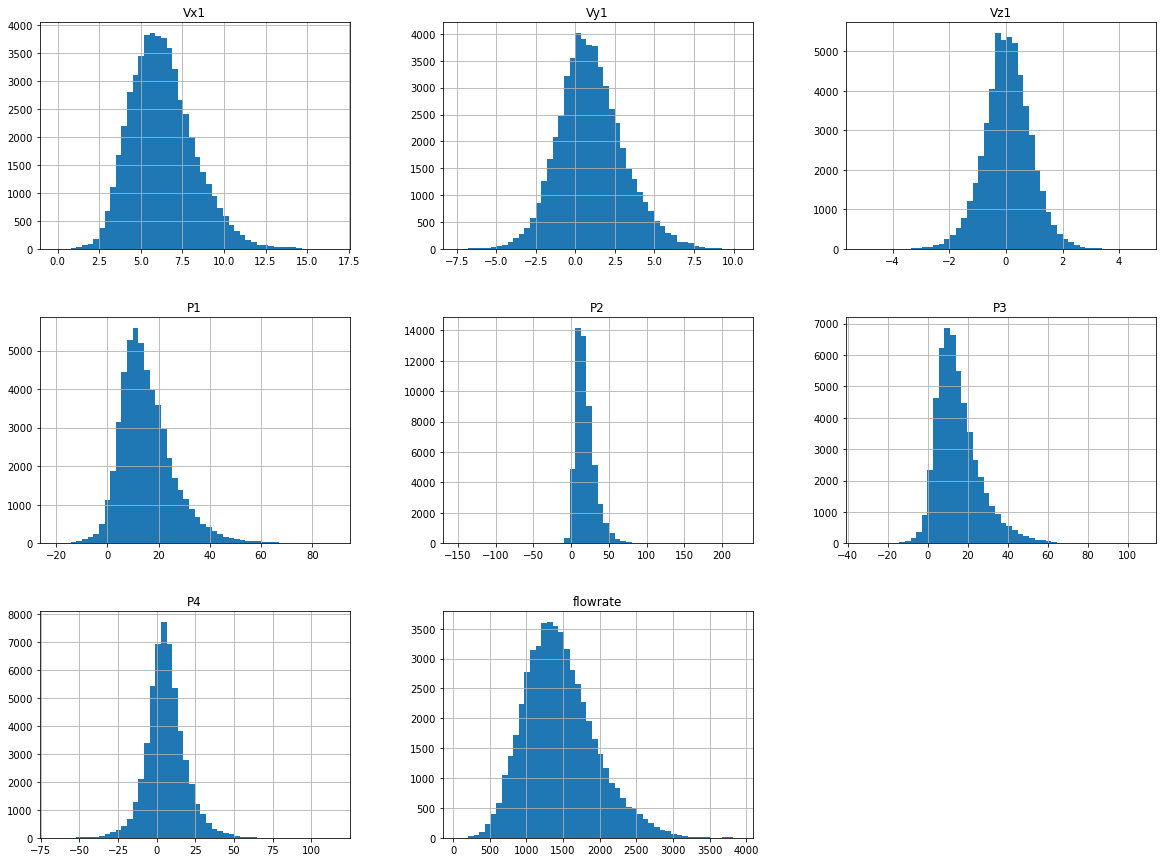

In [3]:
# Drop the index column
data = data.drop(['Unnamed: 0'], axis=1)

import matplotlib.pyplot as plt

# Perfrom Exploratory Data Analysis
data.hist(bins=50, figsize=(20,15))

In [4]:
data['flowrate'].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

count    53069.000000
mean      1459.690101
std        482.004263
min         48.613896
10%        885.894840
20%       1050.576868
30%       1179.695183
40%       1296.517302
50%       1409.731610
60%       1528.363684
70%       1667.297100
80%       1839.901344
90%       2104.497622
max       3896.046748
Name: flowrate, dtype: float64

In [5]:
import numpy as np

data["flowrate_cat"] = pd.cut(data["flowrate"], 
                            bins=[885.89, 1050.58, 1179.70, 1296.52, 1409.73, 1528.36, 1667.3, 1839.9, 2104.5, np.inf], 
                            right=False)

data["flowrate_cat"].value_counts()

[1528.36, 1667.3)     5308
[2104.5, inf)         5307
[1839.9, 2104.5)      5307
[1667.3, 1839.9)      5307
[1179.7, 1296.52)     5307
[1050.58, 1179.7)     5307
[885.89, 1050.58)     5307
[1409.73, 1528.36)    5306
[1296.52, 1409.73)    5306
Name: flowrate_cat, dtype: int64

In [6]:
# Drop null values
data = data.dropna()

from sklearn.model_selection import train_test_split

# Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(data.drop(['flowrate', "flowrate_cat"], axis=1), data['flowrate'], test_size=0.3, random_state=42, stratify=data['flowrate_cat'])

array([[<AxesSubplot:title={'center':'Vx1'}>,
        <AxesSubplot:title={'center':'Vy1'}>,
        <AxesSubplot:title={'center':'Vz1'}>],
       [<AxesSubplot:title={'center':'P1'}>,
        <AxesSubplot:title={'center':'P2'}>,
        <AxesSubplot:title={'center':'P3'}>],
       [<AxesSubplot:title={'center':'P4'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

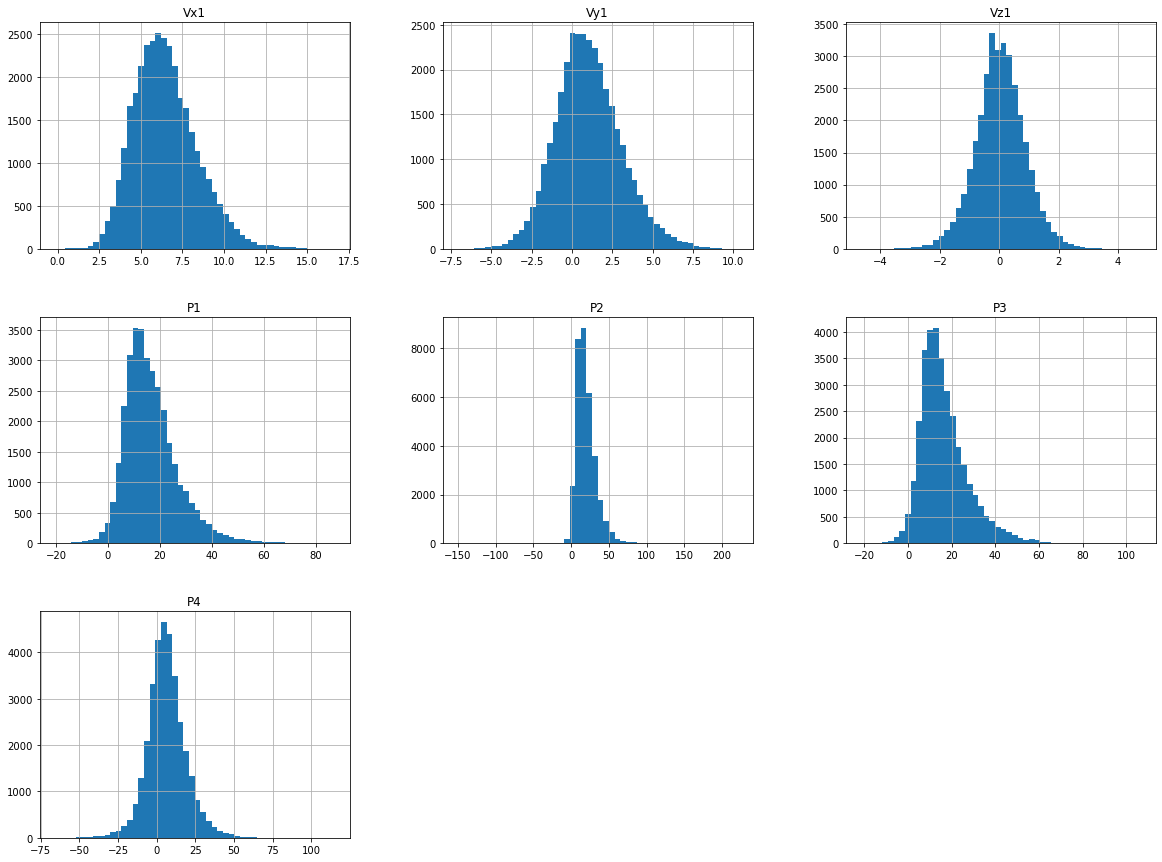

In [7]:
X_train.hist(bins=50, figsize=(20,15))

array([[<AxesSubplot:title={'center':'Vx1'}>,
        <AxesSubplot:title={'center':'Vy1'}>,
        <AxesSubplot:title={'center':'Vz1'}>],
       [<AxesSubplot:title={'center':'P1'}>,
        <AxesSubplot:title={'center':'P2'}>,
        <AxesSubplot:title={'center':'P3'}>],
       [<AxesSubplot:title={'center':'P4'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

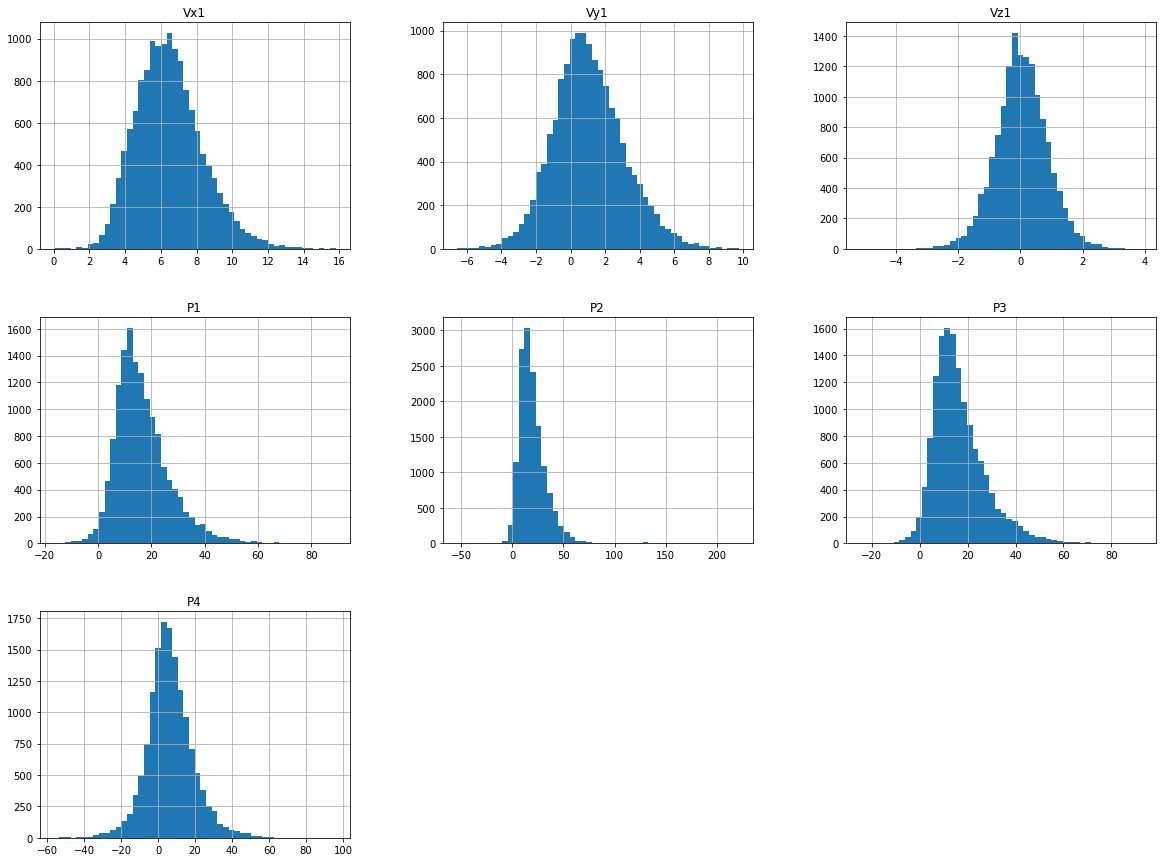

In [8]:
X_test.hist(bins=50, figsize=(20,15))

In [9]:
# Artificial Neural Network with tensorflow
import tensorflow as tf
import math
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Build the ANN model to predict the flowrate with normalization
def ANN(n_layers=2, n_neutrons=16, optimizer='adam', epochs=50, activation='relu', loss='mse'):
    model = tf.keras.models.Sequential()

    # Add the input layer and the first hidden layer
    model.add(tf.keras.layers.Dense(units=n_neutrons, input_dim=X_train.shape[1], activation=activation))

    # Add the rest of the hidden layers
    for i in range(1, n_layers):
        model.add(tf.keras.layers.Dense(units=n_neutrons, activation=activation))

    # Output layer
    model.add(tf.keras.layers.Dense(units=1, activation='linear'))
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Wrap model into scikit-learn
model =  KerasRegressor(build_fn=ANN, verbose = False)

# Use GridSearchCV to find the best parameters
param_grid = {
    'n_layers': [2, 4, 8],
    'n_neutrons': [16, 32],
    'optimizer': ['adam'],
    'epochs': [50],
    'activation': ['relu'],
    'loss': ['mse']
}
ann_gs = GridSearchCV(estimator = model, param_grid = param_grid, cv=3, scoring='neg_mean_squared_error')
ann_gs.fit(X_train, y_train, verbose=0)

# Evaluate the model
print("Best parameters set found on development set:")
print()
print(ann_gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = ann_gs.cv_results_['mean_test_score']
stds = ann_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, ann_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

2021-11-24 05:10:44.874264: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-24 05:10:48.047918: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-24 05:10:48.088023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 05:10:48.088572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-11-24 05:10:48.088627: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-24 05:10:48.180379: I tensorflow/stream_executor/pla

Best parameters set found on development set:

{'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 32, 'optimizer': 'adam'}

Grid scores on development set:

-79492.971 (+/-2272.782) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 2, 'n_neutrons': 16, 'optimizer': 'adam'}
-77531.668 (+/-1864.953) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 2, 'n_neutrons': 32, 'optimizer': 'adam'}
-78054.932 (+/-1631.513) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 16, 'optimizer': 'adam'}
-75286.096 (+/-977.435) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 32, 'optimizer': 'adam'}
-77169.922 (+/-2892.412) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 8, 'n_neutrons': 16, 'optimizer': 'adam'}
-76202.422 (+/-1071.164) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 8, 'n_neutrons': 32, 'optimizer': 'adam'}



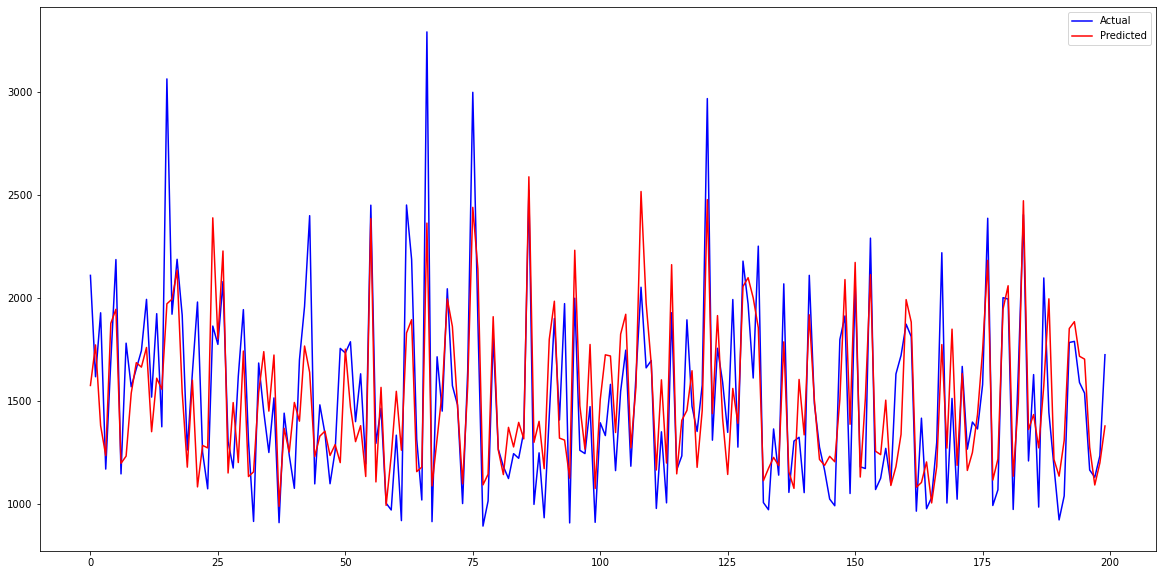

In [12]:
# Get the predictions
y_pred = ann_gs.predict(X_test)

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(200), y_test[:200], color='blue', label='Actual')
plt.plot(range(200), y_pred[:200], color='red', label='Predicted')
plt.legend()
plt.show()

In [15]:
# Update GridSearchCV with new parameters
# Change the number of layers to neutron each layer
param_grid_2 = {
    'n_layers': [4],
    'n_neutrons': [32, 64, 128, 256],
    'optimizer': ['adam'],
    'epochs': [50],
    'activation': ['relu'],
    'loss': ['mse']
}
ann_gs = GridSearchCV(estimator = model, param_grid = param_grid_2, cv=3, scoring='neg_mean_squared_error')
ann_gs.fit(X_train, y_train, verbose=0)

# Evaluate the model
print("Best parameters set found on development set:")
print()
print(ann_gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = ann_gs.cv_results_['mean_test_score']
stds = ann_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, ann_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 256, 'optimizer': 'adam'}

Grid scores on development set:

-76296.650 (+/-2229.289) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 32, 'optimizer': 'adam'}
-74968.914 (+/-619.078) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 64, 'optimizer': 'adam'}
-75792.028 (+/-2294.317) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 128, 'optimizer': 'adam'}
-74237.970 (+/-2001.304) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 256, 'optimizer': 'adam'}


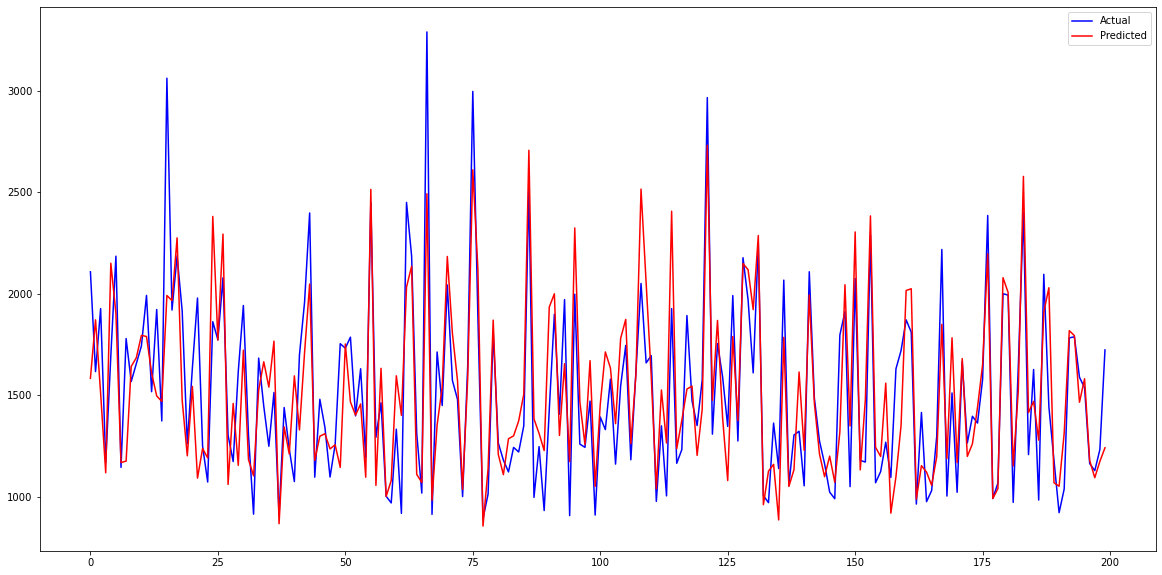

In [16]:
# Get the predictions
y_pred = ann_gs.predict(X_test)

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(200), y_test[:200], color='blue', label='Actual')
plt.plot(range(200), y_pred[:200], color='red', label='Predicted')
plt.legend()
plt.show()

In [17]:
# Update GridSearchCV with new parameters
# Change the number of layers to neutron each layer
param_grid_3 = {
    'n_layers': [4],
    'n_neutrons': [256, 1024, 2048],
    'optimizer': ['adam'],
    'epochs': [50],
    'activation': ['relu'],
    'loss': ['mse']
}
ann_gs = GridSearchCV(estimator = model, param_grid = param_grid_3, cv=3, scoring='neg_mean_squared_error')
ann_gs.fit(X_train, y_train, verbose=0)

# Evaluate the model
print("Best parameters set found on development set:")
print()
print(ann_gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = ann_gs.cv_results_['mean_test_score']
stds = ann_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, ann_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 1024, 'optimizer': 'adam'}

Grid scores on development set:

-79485.202 (+/-17905.494) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 256, 'optimizer': 'adam'}
-73695.166 (+/-2891.161) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 1024, 'optimizer': 'adam'}
-73899.732 (+/-4161.780) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 2048, 'optimizer': 'adam'}


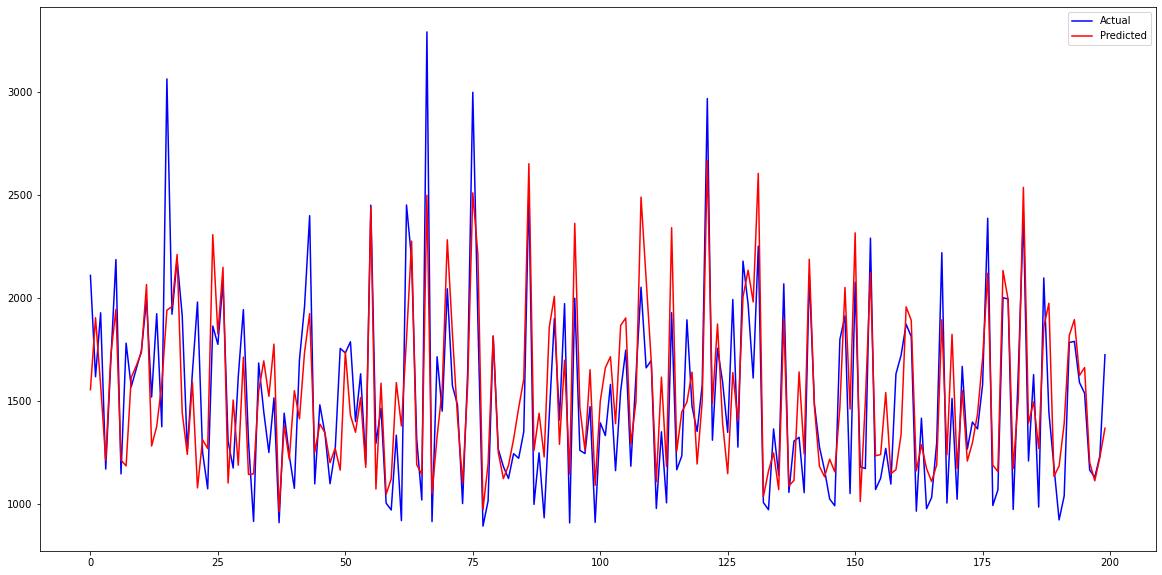

In [18]:
# Get the predictions
y_pred = ann_gs.predict(X_test)

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(200), y_test[:200], color='blue', label='Actual')
plt.plot(range(200), y_pred[:200], color='red', label='Predicted')
plt.legend()
plt.show()

In [19]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model with best parameters
model = ANN(n_layers=4, n_neutrons=1024, optimizer='adam', epochs=50, activation='relu', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.3f" % mse)


MSE: 68402.095


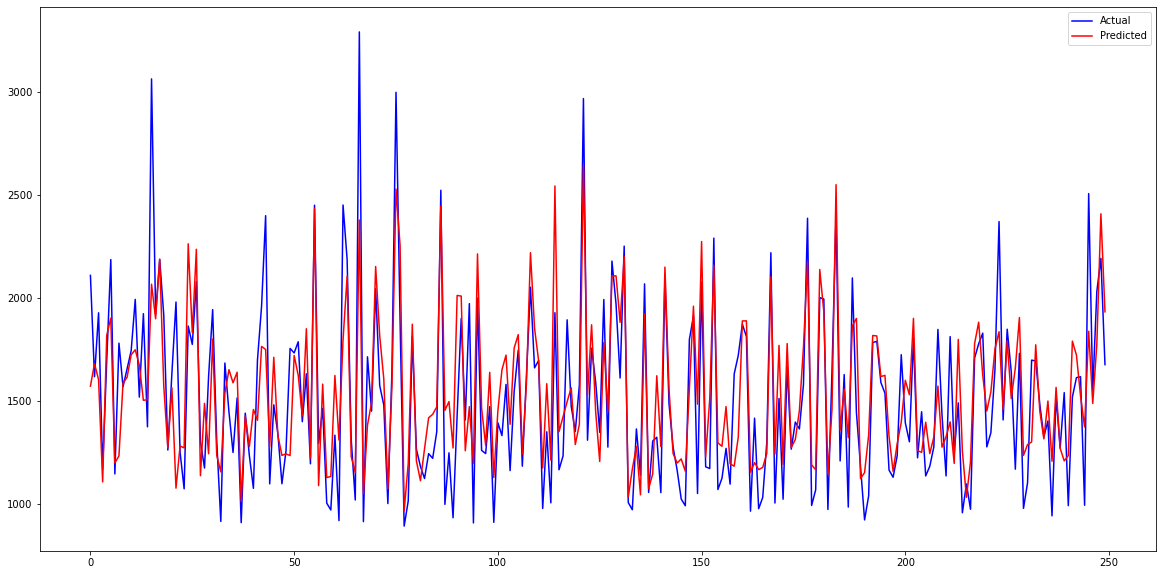

In [22]:
# Get the predictions
y_pred = model.predict(X_test)

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(250), y_test[:250], color='blue', label='Actual')
plt.plot(range(250), y_pred[:250], color='red', label='Predicted')
plt.legend()
plt.show()

In [24]:
# Wrap model into scikit-learn
model =  KerasRegressor(build_fn=ANN, verbose = False)

# Update GridSearchCV with new parameters
# Change the number of layers to neutron each layer
param_grid_4 = {
    'n_layers': [4, 8, 16],
    'n_neutrons': [1024],
    'optimizer': ['adam'],
    'epochs': [50],
    'activation': ['relu'],
    'loss': ['mse']
}
ann_gs = GridSearchCV(estimator = model, param_grid = param_grid_4, cv=3, scoring='neg_mean_squared_error')
ann_gs.fit(X_train, y_train, verbose=0)

# Evaluate the model
print("Best parameters set found on development set:")
print()
print(ann_gs.best_params_)
print()
print("Grid scores on development set:")
print()
means = ann_gs.cv_results_['mean_test_score']
stds = ann_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, ann_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 1024, 'optimizer': 'adam'}

Grid scores on development set:

-71374.263 (+/-225.346) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 4, 'n_neutrons': 1024, 'optimizer': 'adam'}
-77092.018 (+/-2910.301) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 8, 'n_neutrons': 1024, 'optimizer': 'adam'}
-76939.668 (+/-4491.125) for {'activation': 'relu', 'epochs': 50, 'loss': 'mse', 'n_layers': 16, 'n_neutrons': 1024, 'optimizer': 'adam'}


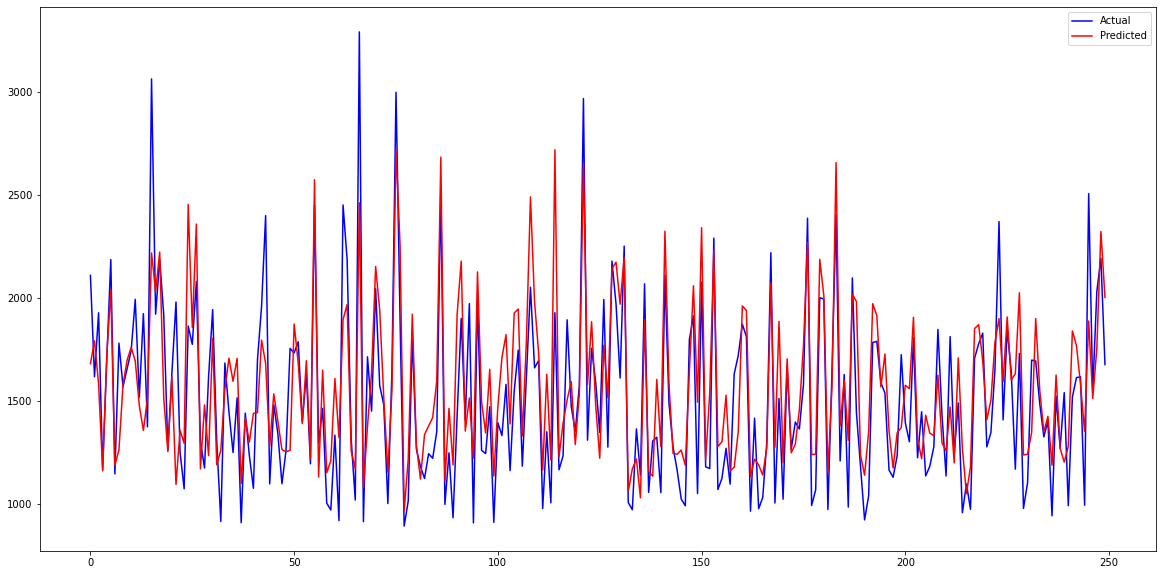

In [26]:
# Get the predictions
y_pred = ann_gs.predict(X_test)

# Plot the predictions and actual values
plt.figure(figsize=(20,10))
plt.plot(range(250), y_test[:250], color='blue', label='Actual')
plt.plot(range(250), y_pred[:250], color='red', label='Predicted')
plt.legend()
plt.show()